In [1]:
import vtk
import mayavi

print("VTK version:", vtk.vtkVersion.GetVTKVersion())
print("Mayavi version:", mayavi.__version__)

VTK version: 9.2.6
Mayavi version: 4.8.1


In [1]:
import numpy as np
from mayavi import mlab

# Generate some random data
x, y = np.mgrid[-5:5:100j, -5:5:100j]
z = np.sin(x**2 + y**2) / (x**2 + y**2)

# Create a Mayavi figure
fig = mlab.figure()

# Plot the surface
surf = mlab.surf(x, y, z, colormap='cool')

# Display the Mayavi plot
mlab.show()


In [2]:
%pip install scikit-learn

  Obtaining dependency information for scikit-learn from https://files.pythonhosted.org/packages/2d/30/3afb8bcb785653254eb646ff2680ec4d637b40b06f4b046aca17b5e086b0/scikit_learn-1.3.0-cp39-cp39-win_amd64.whl.metadata
  Obtaining dependency information for numpy>=1.17.3 from https://files.pythonhosted.org/packages/df/18/181fb40f03090c6fbd061bb8b1f4c32453f7c602b0dc7c08b307baca7cd7/numpy-1.25.2-cp39-cp39-win_amd64.whl.metadata
  Obtaining dependency information for scipy>=1.5.0 from https://files.pythonhosted.org/packages/e9/20/2d0561ab54d857365926c5b53538369a7b8d6ccbffaca509305b074028cd/scipy-1.11.2-cp39-cp39-win_amd64.whl.metadata
     ---------------------------------------- 0.0/59.1 kB ? eta -:--:--
     ------ --------------------------------- 10.2/59.1 kB ? eta -:--:--
     -------------------------- ----------- 41.0/59.1 kB 653.6 kB/s eta 0:00:01
     -------------------------------------- 59.1/59.1 kB 519.8 kB/s eta 0:00:00
  Obtaining dependency information for joblib>=1.1.1 from 

In [3]:
%pip install vtk

     ---------------------------------------- 0.0/48.8 MB ? eta -:--:--
     ---------------------------------------- 0.0/48.8 MB ? eta -:--:--
     --------------------------------------- 0.0/48.8 MB 330.3 kB/s eta 0:02:28
     --------------------------------------- 0.1/48.8 MB 491.5 kB/s eta 0:01:40
     ---------------------------------------- 0.2/48.8 MB 1.2 MB/s eta 0:00:41
     ---------------------------------------- 0.4/48.8 MB 1.8 MB/s eta 0:00:28
     ---------------------------------------- 0.5/48.8 MB 2.0 MB/s eta 0:00:25
     ---------------------------------------- 0.6/48.8 MB 2.1 MB/s eta 0:00:23
      --------------------------------------- 0.9/48.8 MB 2.6 MB/s eta 0:00:19
      --------------------------------------- 1.0/48.8 MB 2.7 MB/s eta 0:00:19
      --------------------------------------- 1.2/48.8 MB 2.6 MB/s eta 0:00:19
     - -------------------------------------- 1.3/48.8 MB 2.7 MB/s eta 0:00:18
     - -------------------------------------- 1.5/48.8 MB 2.7 MB

In [18]:
# %pip install apptools
# %pip install envisage
# %pip install pyface
# %pip install traits
%pip install traitsui

Note: you may need to restart the kernel to use updated packages.


In [19]:
%pip install mayavi


  Using cached mayavi-4.8.1.tar.gz (20.6 MB)
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
  Created wheel for mayavi: filename=mayavi-4.8.1-cp39-cp39-win_amd64.whl size=16133817 sha256=64b77a5a9b83ea488166574beb013cf79e3bae47367810d470f18e8c3fc8ceda
  Stored in directory: c:\users\sawa\appdata\local\pip\cache\wheels\5e\9c\2b\fa9f58121e0d2c709417504c8ebe52b07e4d859537fa52eda9
Successfully built mayavi


In [6]:
%pip install pandas

  Obtaining dependency information for pandas from https://files.pythonhosted.org/packages/9a/f2/0ad053856debbe90c83de1b4f05915f85fd2146f20faf9daa3b320d36df3/pandas-2.0.3-cp39-cp39-win_amd64.whl.metadata
     ---------------------------------------- 0.0/502.3 kB ? eta -:--:--
      --------------------------------------- 10.2/502.3 kB ? eta -:--:--
     ------- ------------------------------- 92.2/502.3 kB 1.3 MB/s eta 0:00:01
     ----------------- -------------------- 225.3/502.3 kB 2.3 MB/s eta 0:00:01
     --------------------------- ---------- 358.4/502.3 kB 2.5 MB/s eta 0:00:01
     -------------------------------------  501.8/502.3 kB 2.6 MB/s eta 0:00:01
     -------------------------------------- 502.3/502.3 kB 2.0 MB/s eta 0:00:00
     ---------------------------------------- 0.0/341.8 kB ? eta -:--:--
     ------------------ ------------------- 163.8/341.8 kB 5.0 MB/s eta 0:00:01
     -------------------------------------  337.9/341.8 kB 5.2 MB/s eta 0:00:01
     -----------

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

# Load the dataset
df = pd.read_csv('winequality-red.csv',sep=';')
df


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
1,7.8,0.880,0.00,2.6,0.098,25.0,67.0,0.99680,3.20,0.68,9.8,5
2,7.8,0.760,0.04,2.3,0.092,15.0,54.0,0.99700,3.26,0.65,9.8,5
3,11.2,0.280,0.56,1.9,0.075,17.0,60.0,0.99800,3.16,0.58,9.8,6
4,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
...,...,...,...,...,...,...,...,...,...,...,...,...
1594,6.2,0.600,0.08,2.0,0.090,32.0,44.0,0.99490,3.45,0.58,10.5,5
1595,5.9,0.550,0.10,2.2,0.062,39.0,51.0,0.99512,3.52,0.76,11.2,6
1596,6.3,0.510,0.13,2.3,0.076,29.0,40.0,0.99574,3.42,0.75,11.0,6
1597,5.9,0.645,0.12,2.0,0.075,32.0,44.0,0.99547,3.57,0.71,10.2,5


In [3]:
origcols=list(df.columns)
origcols

['fixed acidity',
 'volatile acidity',
 'citric acid',
 'residual sugar',
 'chlorides',
 'free sulfur dioxide',
 'total sulfur dioxide',
 'density',
 'pH',
 'sulphates',
 'alcohol',
 'quality']

# статистика по значениям качества:

In [4]:
df['quality'].value_counts()

quality
5    681
6    638
7    199
4     53
8     18
3     10
Name: count, dtype: int64

In [5]:
df['column_bin'] = pd.cut(df['quality'], bins=[0, 6.5, 8], include_lowest=True,right=True)
bin_counts = df['column_bin'].value_counts()
print(bin_counts)


column_bin
(-0.001, 6.5]    1382
(6.5, 8.0]        217
Name: count, dtype: int64


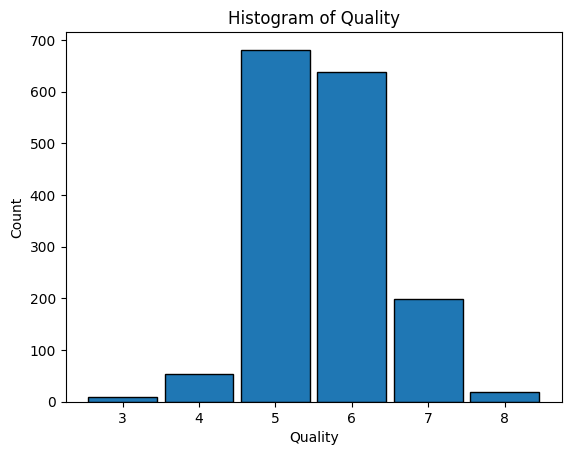

In [6]:
# Calculate counts of each unique 'quality' value
counts = df['quality'].value_counts().sort_index()

# Calculate bin centers (which are just the unique 'quality' values)
bin_centers = counts.index

# Create new figure
plt.figure()

# Use bar to plot histogram with centered bars
plt.bar(bin_centers, counts, width=0.9, align='center', edgecolor='black', tick_label=bin_centers)

# Add labels and title
plt.xlabel('Quality')
plt.ylabel('Count')
plt.title('Histogram of Quality')

# Show the plot
plt.show()

In [7]:
df[origcols]

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
1,7.8,0.880,0.00,2.6,0.098,25.0,67.0,0.99680,3.20,0.68,9.8,5
2,7.8,0.760,0.04,2.3,0.092,15.0,54.0,0.99700,3.26,0.65,9.8,5
3,11.2,0.280,0.56,1.9,0.075,17.0,60.0,0.99800,3.16,0.58,9.8,6
4,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
...,...,...,...,...,...,...,...,...,...,...,...,...
1594,6.2,0.600,0.08,2.0,0.090,32.0,44.0,0.99490,3.45,0.58,10.5,5
1595,5.9,0.550,0.10,2.2,0.062,39.0,51.0,0.99512,3.52,0.76,11.2,6
1596,6.3,0.510,0.13,2.3,0.076,29.0,40.0,0.99574,3.42,0.75,11.0,6
1597,5.9,0.645,0.12,2.0,0.075,32.0,44.0,0.99547,3.57,0.71,10.2,5


In [8]:
# Analyze the distributions of variables and their correlation with the target variable

# Split the data into features and target variable
X = df[origcols].drop('quality', axis=1)
y = df['quality']

# Convert the target variable into a categorical variable
y = y.apply(lambda x: 'good wine' if x > 6.5 else 'bad wine')

# Encode the target variable
le = LabelEncoder()
y_le = le.fit_transform(y)


In [9]:
dff = pd.DataFrame(y_le, columns=['ColumnName'])
dff['ColumnName'].value_counts()

ColumnName
0    1382
1     217
Name: count, dtype: int64

In [10]:

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_le, test_size=0.2, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
#применить так же стандартизацию к полному ряду для визуализации
X_t = scaler.transform(X)


from sklearn.metrics import make_scorer, accuracy_score
from time import time
# Define the SVM model
svm = SVC()

# Define the hyperparameters to tune
param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': [0.1, 1, 10, 100],
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid']
}
param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': [0.1, 1, 10, 100],
    'kernel': ['rbf']
}

# Perform grid search to find the best hyperparameters
grid_search = GridSearchCV(estimator=svm, param_grid=param_grid, cv=5,verbose=4,n_jobs=-1)
grid_search.fit(X_train, y_train)


Fitting 5 folds for each of 16 candidates, totalling 80 fits


GridSearchCV(cv=5, estimator=SVC(), n_jobs=-1,
             param_grid={'C': [0.1, 1, 10, 100], 'gamma': [0.1, 1, 10, 100],
                         'kernel': ['rbf']},
             verbose=4)

In [14]:
# попытка организовать индикатор прогресса, оказалось, вызов колбэк происходит только при n_jobs=1, это очень долгий расчет..
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.utils.validation import check_X_y, check_is_fitted
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from itertools import product
import time

class TimedSVC(BaseEstimator, ClassifierMixin):
    callback = None
    def __init__(self, *args, **kwargs):
        if 'callback' in kwargs:
            TimedSVC.callback = kwargs.pop('callback')
        self.svc = SVC(*args, **kwargs)

    def fit(self, X, y):
        X, y = check_X_y(X, y)        
        start = time.time()
        
        self.svc.fit(X, y)
        elapsed_time = time.time()-start
        #Editing to call the callback with parameters and elapsed time
        if self.callback: 
            TimedSVC.callback(self.svc.get_params(), elapsed_time)
        
        # for the check_is_fitted in the predict method
        self.is_fitted_ = True
        return self

    def predict(self, X):
        check_is_fitted(self)
        return self.svc.predict(X)
    
    def get_params(self, deep=True):
        return self.svc.get_params(deep)
    
    def set_params(self, **params):
        self.svc.set_params(**params)
        super().set_params(**params)
        return self

def create_callback(total_combinations):
    times_of_combinations = {} # storing time of each fit per combination
    avg_time_per_fit = [0]
    def print_params_time(params, elapsed_time):
        frozen_params = frozenset(params.items())
        if frozen_params in times_of_combinations:
            times_of_combinations[frozen_params].append(elapsed_time)
        else:
            times_of_combinations[frozen_params] = [elapsed_time]
        total_times = [sum(times) for times in times_of_combinations.values()]
        avg_time_per_fit[0] = sum(total_times) / len(total_times)
        remaining_combinations = total_combinations - len(times_of_combinations)
        estimated_remaining_time = max(avg_time_per_fit[0] * remaining_combinations, 0)
        print("Fit done, params: ", params)
        print("Time elapsed for current fit: ", elapsed_time, "s")
        print(f"{len(times_of_combinations)} unique combinations completed. Average time per combination: {avg_time_per_fit[0]} s")
        print(f"{remaining_combinations} combinations remaining. Estimated remaining time: {estimated_remaining_time} s")
    return print_params_time

param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': [0.1, 1, 10, 100],
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'] #
}

combination_counts = len(list(product(*param_grid.values())))

# Creating the callback with total combination counts
print_params_time = create_callback(combination_counts)

# Pass the callback
svm = TimedSVC(callback=print_params_time)

grid_search = GridSearchCV(estimator=svm, param_grid=param_grid, cv=5,  n_jobs=-1)
grid_search.fit(X_train, y_train)

Fit done, params:  {'C': 1, 'break_ties': False, 'cache_size': 200, 'class_weight': None, 'coef0': 0.0, 'decision_function_shape': 'ovr', 'degree': 3, 'gamma': 1, 'kernel': 'rbf', 'max_iter': -1, 'probability': False, 'random_state': None, 'shrinking': True, 'tol': 0.001, 'verbose': False}
Time elapsed for current fit:  0.0830070972442627 s
1 unique combinations completed. Average time per combination: 0.0830070972442627 s
63 combinations remaining. Estimated remaining time: 5.22944712638855 s


GridSearchCV(cv=5,
             estimator=TimedSVC(C=1.0, break_ties=False, cache_size=200,
                                class_weight=None, coef0=0.0,
                                decision_function_shape='ovr', degree=3,
                                gamma='scale', kernel='rbf', max_iter=-1,
                                probability=False, random_state=None,
                                shrinking=True, tol=0.001, verbose=False),
             n_jobs=-1,
             param_grid={'C': [0.1, 1, 10, 100], 'gamma': [0.1, 1, 10, 100],
                         'kernel': ['linear', 'poly', 'rbf', 'sigmoid']})

In [11]:

# Print the best hyperparameters
print("Best hyperparameters:", grid_search.best_params_)

# Train the model with the best hyperparameters
best_model = grid_search.best_estimator_
best_model.fit(X_train, y_train)

# Predict the labels for the test set
y_pred = best_model.predict(X_test)

# Evaluate the model using the accuracy metric
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Optionally, you can also print the confusion matrix
confusion_mat = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(confusion_mat)

Best hyperparameters: {'C': 1, 'gamma': 1, 'kernel': 'rbf'}
Accuracy: 0.890625
Confusion Matrix:
[[271   2]
 [ 33  14]]


можно сделать вывод, что модель хорошо справляется с предсказанием положительного класса (большинства примеров), но менее точна в предсказании отрицательного класса. Это может быть связано с несбалансированностью классов в данных

In [12]:
print(X[:5],y_le[:5])



   fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0            7.4              0.70         0.00             1.9      0.076   
1            7.8              0.88         0.00             2.6      0.098   
2            7.8              0.76         0.04             2.3      0.092   
3           11.2              0.28         0.56             1.9      0.075   
4            7.4              0.70         0.00             1.9      0.076   

   free sulfur dioxide  total sulfur dioxide  density    pH  sulphates  \
0                 11.0                  34.0   0.9978  3.51       0.56   
1                 25.0                  67.0   0.9968  3.20       0.68   
2                 15.0                  54.0   0.9970  3.26       0.65   
3                 17.0                  60.0   0.9980  3.16       0.58   
4                 11.0                  34.0   0.9978  3.51       0.56   

   alcohol  
0      9.4  
1      9.8  
2      9.8  
3      9.8  
4      9.4   [0 0 0 0

In [18]:
from sklearn.model_selection import ParameterGrid
param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': [0.1, 1, 10, 100],
    'kernel': ['rbf']
}

classifiers = []

for params in ParameterGrid(param_grid):
    C = params['C']
    gamma = params['gamma']
    kernel = params['kernel']
  
    clf = SVC(C=C, gamma=gamma, kernel=kernel)
    clf.fit(X_t, y_le)
  
    classifiers.append((C, gamma, clf))


# Visualization

plt.figure(figsize=(8, 6))
xx, yy = np.meshgrid(np.linspace(-3, 3, 200), np.linspace(-3, 3, 200))

n_C = len(param_grid['C'])
n_gamma = len(param_grid['gamma'])

for i, (C, gamma, clf) in enumerate(classifiers):
    Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.subplot(n_C, n_gamma, i + 1)
    plt.title("gamma={}, C={}".format(gamma, C), size="medium")

    plt.pcolormesh(xx, yy, -Z, cmap=plt.cm.RdBu)
    plt.scatter(X[:, 0], X[:, 1], c=y_le, cmap=plt.cm.RdBu_r, edgecolors="k")
    plt.xticks(())
    plt.yticks(())
    plt.axis("tight")

In [16]:
from sklearn.model_selection import ParameterGrid
from sklearn.decomposition import PCA
from sklearn.svm import SVC
import numpy as np
import matplotlib.pyplot as plt

param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': [0.1, 1, 10, 100],
    'kernel': ['rbf']
}

classifiers = []

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_t)


In [12]:
# print(xx,yy,sep='\n\n')
print(X_pca[:, 0].min(),X_pca[:, 0].min())
print(X_pca[:, 1].max(),X_pca[:, 1].max())

NameError: name 'X_pca' is not defined

ValueError: X has 2 features, but SVC is expecting 3 features as input.

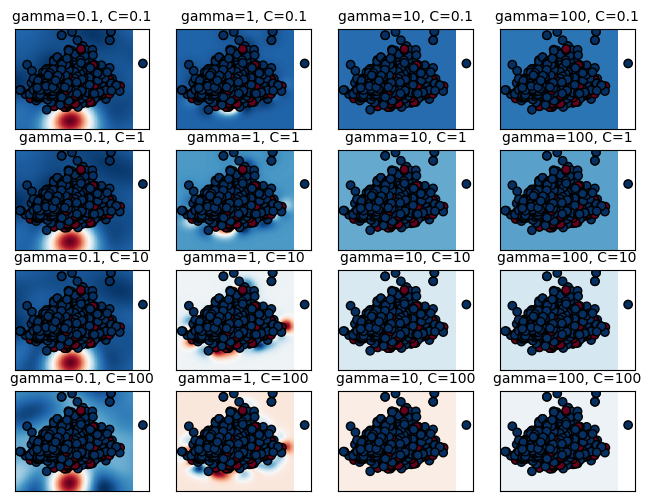

In [42]:

for params in ParameterGrid(param_grid):
    C = params['C']
    gamma = params['gamma']
    kernel = params['kernel']
  
    clf = SVC(C=C, gamma=gamma, kernel=kernel)
    clf.fit(X_pca, y_le)
  
    classifiers.append((C, gamma, clf))

# Visualization

plt.figure(figsize=(8, 6))
mi=-6
ma=7
xx, yy = np.meshgrid(np.linspace(mi, ma, 200), np.linspace(mi, ma, 200))

n_C = len(param_grid['C'])
n_gamma = len(param_grid['gamma'])

for i, (C, gamma, clf) in enumerate(classifiers):
    Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.subplot(n_C, n_gamma, i + 1)
    plt.title(f"gamma={gamma}, C={C}", size="medium")

    plt.pcolormesh(xx, yy, -Z, cmap=plt.cm.RdBu)
    plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_le, cmap=plt.cm.RdBu_r, edgecolors="k")
    plt.xticks(())
    plt.yticks(())
    plt.axis("tight")

plt.show()

In [55]:
X_pca

array([[-1.5742207 ,  0.46478227, -1.82356793],
       [-0.79678773,  1.85546446, -0.91598547],
       [-0.73420797,  0.87823584, -1.18818952],
       ...,
       [-1.49646119,  0.32744302,  1.09992893],
       [-2.30446791,  1.00729709,  0.58617072],
       [-0.46804294, -0.54171334,  1.61881129]])

In [13]:
plt.figure(figsize=(8, 6))
C=1
gamma=1
clf = SVC(C=C, gamma=gamma)
clf.fit(X_pca, y_le)
Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
plt.title(f"gamma={gamma}, C={C}", size="medium")
# визуализируем влияние параметра на функцию принятия решения
plt.pcolormesh(xx, yy, -Z, cmap=plt.cm.RdBu)
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_le, cmap=plt.cm.RdBu_r, edgecolors="k")
plt.xticks(())
plt.yticks(())
plt.axis("tight")

NameError: name 'X_pca' is not defined

<Figure size 800x600 with 0 Axes>

ValueError: 'c' argument must be a color, a sequence of colors, or a sequence of numbers, not array([[[[0.27489427, 0.58415994, 0.76885813, 1.        ],
         [0.27489427, 0.58415994, 0.76885813, 1.        ],
         [0.27489427, 0.58415994, 0.76885813, 1.        ],
         ...,
         [0.27489427, 0.58415994, 0.76885813, 1.        ],
         [0.27489427, 0.58415994, 0.76885813, 1.        ],
         [0.27489427, 0.58415994, 0.76885813, 1.        ]],

        [[0.27489427, 0.58415994, 0.76885813, 1.        ],
         [0.27489427, 0.58415994, 0.76885813, 1.        ],
         [0.27489427, 0.58415994, 0.76885813, 1.        ],
         ...,
         [0.27489427, 0.58415994, 0.76885813, 1.        ],
         [0.27489427, 0.58415994, 0.76885813, 1.        ],
         [0.27489427, 0.58415994, 0.76885813, 1.        ]],

        [[0.27489427, 0.58415994, 0.76885813, 1.        ],
         [0.27489427, 0.58415994, 0.76885813, 1.        ],
         [0.27489427, 0.58415994, 0.76885813, 1.        ],
         ...,
         [0.27489427, 0.58415994, 0.76885813, 1.        ],
         [0.27489427, 0.58415994, 0.76885813, 1.        ],
         [0.27489427, 0.58415994, 0.76885813, 1.        ]],

        ...,

        [[0.27489427, 0.58415994, 0.76885813, 1.        ],
         [0.27489427, 0.58415994, 0.76885813, 1.        ],
         [0.27489427, 0.58415994, 0.76885813, 1.        ],
         ...,
         [0.27489427, 0.58415994, 0.76885813, 1.        ],
         [0.27489427, 0.58415994, 0.76885813, 1.        ],
         [0.27489427, 0.58415994, 0.76885813, 1.        ]],

        [[0.27489427, 0.58415994, 0.76885813, 1.        ],
         [0.27489427, 0.58415994, 0.76885813, 1.        ],
         [0.27489427, 0.58415994, 0.76885813, 1.        ],
         ...,
         [0.27489427, 0.58415994, 0.76885813, 1.        ],
         [0.27489427, 0.58415994, 0.76885813, 1.        ],
         [0.27489427, 0.58415994, 0.76885813, 1.        ]],

        [[0.27489427, 0.58415994, 0.76885813, 1.        ],
         [0.27489427, 0.58415994, 0.76885813, 1.        ],
         [0.27489427, 0.58415994, 0.76885813, 1.        ],
         ...,
         [0.27489427, 0.58415994, 0.76885813, 1.        ],
         [0.27489427, 0.58415994, 0.76885813, 1.        ],
         [0.27489427, 0.58415994, 0.76885813, 1.        ]]],


       [[[0.27489427, 0.58415994, 0.76885813, 1.        ],
         [0.27489427, 0.58415994, 0.76885813, 1.        ],
         [0.27489427, 0.58415994, 0.76885813, 1.        ],
         ...,
         [0.27489427, 0.58415994, 0.76885813, 1.        ],
         [0.27489427, 0.58415994, 0.76885813, 1.        ],
         [0.27489427, 0.58415994, 0.76885813, 1.        ]],

        [[0.27489427, 0.58415994, 0.76885813, 1.        ],
         [0.27489427, 0.58415994, 0.76885813, 1.        ],
         [0.27489427, 0.58415994, 0.76885813, 1.        ],
         ...,
         [0.27489427, 0.58415994, 0.76885813, 1.        ],
         [0.27489427, 0.58415994, 0.76885813, 1.        ],
         [0.27489427, 0.58415994, 0.76885813, 1.        ]],

        [[0.27489427, 0.58415994, 0.76885813, 1.        ],
         [0.27489427, 0.58415994, 0.76885813, 1.        ],
         [0.27489427, 0.58415994, 0.76885813, 1.        ],
         ...,
         [0.27489427, 0.58415994, 0.76885813, 1.        ],
         [0.27489427, 0.58415994, 0.76885813, 1.        ],
         [0.27489427, 0.58415994, 0.76885813, 1.        ]],

        ...,

        [[0.27489427, 0.58415994, 0.76885813, 1.        ],
         [0.27489427, 0.58415994, 0.76885813, 1.        ],
         [0.27489427, 0.58415994, 0.76885813, 1.        ],
         ...,
         [0.27489427, 0.58415994, 0.76885813, 1.        ],
         [0.27489427, 0.58415994, 0.76885813, 1.        ],
         [0.27489427, 0.58415994, 0.76885813, 1.        ]],

        [[0.27489427, 0.58415994, 0.76885813, 1.        ],
         [0.27489427, 0.58415994, 0.76885813, 1.        ],
         [0.27489427, 0.58415994, 0.76885813, 1.        ],
         ...,
         [0.27489427, 0.58415994, 0.76885813, 1.        ],
         [0.27489427, 0.58415994, 0.76885813, 1.        ],
         [0.27489427, 0.58415994, 0.76885813, 1.        ]],

        [[0.27489427, 0.58415994, 0.76885813, 1.        ],
         [0.27489427, 0.58415994, 0.76885813, 1.        ],
         [0.27489427, 0.58415994, 0.76885813, 1.        ],
         ...,
         [0.27489427, 0.58415994, 0.76885813, 1.        ],
         [0.27489427, 0.58415994, 0.76885813, 1.        ],
         [0.27489427, 0.58415994, 0.76885813, 1.        ]]],


       [[[0.27489427, 0.58415994, 0.76885813, 1.        ],
         [0.27489427, 0.58415994, 0.76885813, 1.        ],
         [0.27489427, 0.58415994, 0.76885813, 1.        ],
         ...,
         [0.27489427, 0.58415994, 0.76885813, 1.        ],
         [0.27489427, 0.58415994, 0.76885813, 1.        ],
         [0.27489427, 0.58415994, 0.76885813, 1.        ]],

        [[0.27489427, 0.58415994, 0.76885813, 1.        ],
         [0.27489427, 0.58415994, 0.76885813, 1.        ],
         [0.27489427, 0.58415994, 0.76885813, 1.        ],
         ...,
         [0.27489427, 0.58415994, 0.76885813, 1.        ],
         [0.27489427, 0.58415994, 0.76885813, 1.        ],
         [0.27489427, 0.58415994, 0.76885813, 1.        ]],

        [[0.27489427, 0.58415994, 0.76885813, 1.        ],
         [0.27489427, 0.58415994, 0.76885813, 1.        ],
         [0.27489427, 0.58415994, 0.76885813, 1.        ],
         ...,
         [0.27489427, 0.58415994, 0.76885813, 1.        ],
         [0.27489427, 0.58415994, 0.76885813, 1.        ],
         [0.27489427, 0.58415994, 0.76885813, 1.        ]],

        ...,

        [[0.27489427, 0.58415994, 0.76885813, 1.        ],
         [0.27489427, 0.58415994, 0.76885813, 1.        ],
         [0.27489427, 0.58415994, 0.76885813, 1.        ],
         ...,
         [0.27489427, 0.58415994, 0.76885813, 1.        ],
         [0.27489427, 0.58415994, 0.76885813, 1.        ],
         [0.27489427, 0.58415994, 0.76885813, 1.        ]],

        [[0.27489427, 0.58415994, 0.76885813, 1.        ],
         [0.27489427, 0.58415994, 0.76885813, 1.        ],
         [0.27489427, 0.58415994, 0.76885813, 1.        ],
         ...,
         [0.27489427, 0.58415994, 0.76885813, 1.        ],
         [0.27489427, 0.58415994, 0.76885813, 1.        ],
         [0.27489427, 0.58415994, 0.76885813, 1.        ]],

        [[0.27489427, 0.58415994, 0.76885813, 1.        ],
         [0.27489427, 0.58415994, 0.76885813, 1.        ],
         [0.27489427, 0.58415994, 0.76885813, 1.        ],
         ...,
         [0.27489427, 0.58415994, 0.76885813, 1.        ],
         [0.27489427, 0.58415994, 0.76885813, 1.        ],
         [0.27489427, 0.58415994, 0.76885813, 1.        ]]],


       ...,


       [[[0.27489427, 0.58415994, 0.76885813, 1.        ],
         [0.27489427, 0.58415994, 0.76885813, 1.        ],
         [0.27489427, 0.58415994, 0.76885813, 1.        ],
         ...,
         [0.27489427, 0.58415994, 0.76885813, 1.        ],
         [0.27489427, 0.58415994, 0.76885813, 1.        ],
         [0.27489427, 0.58415994, 0.76885813, 1.        ]],

        [[0.27489427, 0.58415994, 0.76885813, 1.        ],
         [0.27489427, 0.58415994, 0.76885813, 1.        ],
         [0.27489427, 0.58415994, 0.76885813, 1.        ],
         ...,
         [0.27489427, 0.58415994, 0.76885813, 1.        ],
         [0.27489427, 0.58415994, 0.76885813, 1.        ],
         [0.27489427, 0.58415994, 0.76885813, 1.        ]],

        [[0.27489427, 0.58415994, 0.76885813, 1.        ],
         [0.27489427, 0.58415994, 0.76885813, 1.        ],
         [0.27489427, 0.58415994, 0.76885813, 1.        ],
         ...,
         [0.27489427, 0.58415994, 0.76885813, 1.        ],
         [0.27489427, 0.58415994, 0.76885813, 1.        ],
         [0.27489427, 0.58415994, 0.76885813, 1.        ]],

        ...,

        [[0.27489427, 0.58415994, 0.76885813, 1.        ],
         [0.27489427, 0.58415994, 0.76885813, 1.        ],
         [0.27489427, 0.58415994, 0.76885813, 1.        ],
         ...,
         [0.27489427, 0.58415994, 0.76885813, 1.        ],
         [0.27489427, 0.58415994, 0.76885813, 1.        ],
         [0.27489427, 0.58415994, 0.76885813, 1.        ]],

        [[0.27489427, 0.58415994, 0.76885813, 1.        ],
         [0.27489427, 0.58415994, 0.76885813, 1.        ],
         [0.27489427, 0.58415994, 0.76885813, 1.        ],
         ...,
         [0.27489427, 0.58415994, 0.76885813, 1.        ],
         [0.27489427, 0.58415994, 0.76885813, 1.        ],
         [0.27489427, 0.58415994, 0.76885813, 1.        ]],

        [[0.27489427, 0.58415994, 0.76885813, 1.        ],
         [0.27489427, 0.58415994, 0.76885813, 1.        ],
         [0.27489427, 0.58415994, 0.76885813, 1.        ],
         ...,
         [0.27489427, 0.58415994, 0.76885813, 1.        ],
         [0.27489427, 0.58415994, 0.76885813, 1.        ],
         [0.27489427, 0.58415994, 0.76885813, 1.        ]]],


       [[[0.27489427, 0.58415994, 0.76885813, 1.        ],
         [0.27489427, 0.58415994, 0.76885813, 1.        ],
         [0.27489427, 0.58415994, 0.76885813, 1.        ],
         ...,
         [0.27489427, 0.58415994, 0.76885813, 1.        ],
         [0.27489427, 0.58415994, 0.76885813, 1.        ],
         [0.27489427, 0.58415994, 0.76885813, 1.        ]],

        [[0.27489427, 0.58415994, 0.76885813, 1.        ],
         [0.27489427, 0.58415994, 0.76885813, 1.        ],
         [0.27489427, 0.58415994, 0.76885813, 1.        ],
         ...,
         [0.27489427, 0.58415994, 0.76885813, 1.        ],
         [0.27489427, 0.58415994, 0.76885813, 1.        ],
         [0.27489427, 0.58415994, 0.76885813, 1.        ]],

        [[0.27489427, 0.58415994, 0.76885813, 1.        ],
         [0.27489427, 0.58415994, 0.76885813, 1.        ],
         [0.27489427, 0.58415994, 0.76885813, 1.        ],
         ...,
         [0.27489427, 0.58415994, 0.76885813, 1.        ],
         [0.27489427, 0.58415994, 0.76885813, 1.        ],
         [0.27489427, 0.58415994, 0.76885813, 1.        ]],

        ...,

        [[0.27489427, 0.58415994, 0.76885813, 1.        ],
         [0.27489427, 0.58415994, 0.76885813, 1.        ],
         [0.27489427, 0.58415994, 0.76885813, 1.        ],
         ...,
         [0.27489427, 0.58415994, 0.76885813, 1.        ],
         [0.27489427, 0.58415994, 0.76885813, 1.        ],
         [0.27489427, 0.58415994, 0.76885813, 1.        ]],

        [[0.27489427, 0.58415994, 0.76885813, 1.        ],
         [0.27489427, 0.58415994, 0.76885813, 1.        ],
         [0.27489427, 0.58415994, 0.76885813, 1.        ],
         ...,
         [0.27489427, 0.58415994, 0.76885813, 1.        ],
         [0.27489427, 0.58415994, 0.76885813, 1.        ],
         [0.27489427, 0.58415994, 0.76885813, 1.        ]],

        [[0.27489427, 0.58415994, 0.76885813, 1.        ],
         [0.27489427, 0.58415994, 0.76885813, 1.        ],
         [0.27489427, 0.58415994, 0.76885813, 1.        ],
         ...,
         [0.27489427, 0.58415994, 0.76885813, 1.        ],
         [0.27489427, 0.58415994, 0.76885813, 1.        ],
         [0.27489427, 0.58415994, 0.76885813, 1.        ]]],


       [[[0.27489427, 0.58415994, 0.76885813, 1.        ],
         [0.27489427, 0.58415994, 0.76885813, 1.        ],
         [0.27489427, 0.58415994, 0.76885813, 1.        ],
         ...,
         [0.27489427, 0.58415994, 0.76885813, 1.        ],
         [0.27489427, 0.58415994, 0.76885813, 1.        ],
         [0.27489427, 0.58415994, 0.76885813, 1.        ]],

        [[0.27489427, 0.58415994, 0.76885813, 1.        ],
         [0.27489427, 0.58415994, 0.76885813, 1.        ],
         [0.27489427, 0.58415994, 0.76885813, 1.        ],
         ...,
         [0.27489427, 0.58415994, 0.76885813, 1.        ],
         [0.27489427, 0.58415994, 0.76885813, 1.        ],
         [0.27489427, 0.58415994, 0.76885813, 1.        ]],

        [[0.27489427, 0.58415994, 0.76885813, 1.        ],
         [0.27489427, 0.58415994, 0.76885813, 1.        ],
         [0.27489427, 0.58415994, 0.76885813, 1.        ],
         ...,
         [0.27489427, 0.58415994, 0.76885813, 1.        ],
         [0.27489427, 0.58415994, 0.76885813, 1.        ],
         [0.27489427, 0.58415994, 0.76885813, 1.        ]],

        ...,

        [[0.27489427, 0.58415994, 0.76885813, 1.        ],
         [0.27489427, 0.58415994, 0.76885813, 1.        ],
         [0.27489427, 0.58415994, 0.76885813, 1.        ],
         ...,
         [0.27489427, 0.58415994, 0.76885813, 1.        ],
         [0.27489427, 0.58415994, 0.76885813, 1.        ],
         [0.27489427, 0.58415994, 0.76885813, 1.        ]],

        [[0.27489427, 0.58415994, 0.76885813, 1.        ],
         [0.27489427, 0.58415994, 0.76885813, 1.        ],
         [0.27489427, 0.58415994, 0.76885813, 1.        ],
         ...,
         [0.27489427, 0.58415994, 0.76885813, 1.        ],
         [0.27489427, 0.58415994, 0.76885813, 1.        ],
         [0.27489427, 0.58415994, 0.76885813, 1.        ]],

        [[0.27489427, 0.58415994, 0.76885813, 1.        ],
         [0.27489427, 0.58415994, 0.76885813, 1.        ],
         [0.27489427, 0.58415994, 0.76885813, 1.        ],
         ...,
         [0.27489427, 0.58415994, 0.76885813, 1.        ],
         [0.27489427, 0.58415994, 0.76885813, 1.        ],
         [0.27489427, 0.58415994, 0.76885813, 1.        ]]]])

<Figure size 800x600 with 0 Axes>

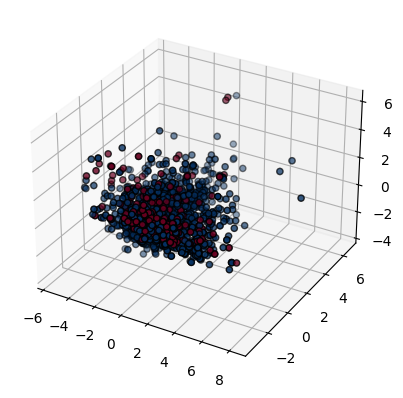

In [15]:
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6))
C=1
gamma=1
clf = SVC(C=C, gamma=gamma)
pca = PCA(n_components=3)
X_pca = pca.fit_transform(X_t)
clf = SVC(C=C, gamma=gamma)
clf.fit(X_pca, y_le)

x = np.linspace(X_pca[:,0].min(), X_pca[:,0].max(), num=100)
y = np.linspace(X_pca[:,1].min(), X_pca[:,1].max(), num=100)
z = np.linspace(X_pca[:,2].min(), X_pca[:,2].max(), num=100)
X, Y, Z = np.meshgrid(x, y, z)

xyz = np.vstack([X.ravel(), Y.ravel(), Z.ravel()]).T
Z_dec_func  = clf.decision_function(xyz).reshape(X.shape)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_pca[:, 0], X_pca[:, 1], X_pca[:, 2], c=y_le, cmap=plt.cm.RdBu_r, edgecolors="k")
ax.scatter(X.ravel(), Y.ravel(), Z.ravel(), facecolors=plt.cm.RdBu(-Z_dec_func ), zorder=10, alpha=.3)
plt.title(f"SVC decision function for gamma={gamma}, C={C}", size="medium")
plt.show()

In [13]:
# %pip install pyqtgraph
# %pip install PyQt5
import PyQt5

# %pip install PySide2 


In [10]:
import PySide2
import traitsui

print('traitsui version:', traitsui.__version__)
print('PySide2 version:', PySide2.__version__)


traitsui version: 8.0.0
PySide2 version: 5.15.2.1


In [16]:
%pip show PyQt5
%pip show mayavi

Name: PyQt5
Version: 5.15.9
Summary: Python bindings for the Qt cross platform application toolkit
Home-page: https://www.riverbankcomputing.com/software/pyqt/
Author: Riverbank Computing Limited
Author-email: info@riverbankcomputing.com
License: GPL v3
Location: c:\users\sawa\.conda\envs\env3.9\lib\site-packages
Requires: PyQt5-Qt5, PyQt5-sip
Required-by: 
Note: you may need to restart the kernel to use updated packages.
Name: mayavi
Version: 4.8.1
Summary: 3D scientific data visualization library and application
Home-page: http://docs.enthought.com/mayavi/mayavi/
Author: Prabhu Ramachandran, et al.
Author-email: prabhu@aero.iitb.ac.in
License: BSD
Location: c:\users\sawa\.conda\envs\env3.9\lib\site-packages
Requires: apptools, envisage, numpy, packaging, pyface, pygments, traits, traitsui, vtk
Required-by: 
Note: you may need to restart the kernel to use updated packages.


In [16]:
import importlib
import os
os.environ['ETS_TOOLKIT'] = 'qt4'

# Assuming you have already imported a module called 'module_name'
import mayavi
from mayavi import mlab
# importlib.reload(mlab)



In [18]:
from sklearn.decomposition import PCA
from sklearn.svm import SVC
import numpy as np
plt.figure(figsize=(8, 6))
C=1
gamma=1
clf = SVC(C=C, gamma=gamma)
pca = PCA(n_components=3)
X_pca = pca.fit_transform(X_t)
clf = SVC(C=C, gamma=gamma)
clf.fit(X_pca, y_le)

x = np.linspace(X_pca[:,0].min(), X_pca[:,0].max(), num=100)
y = np.linspace(X_pca[:,1].min(), X_pca[:,1].max(), num=100)
z = np.linspace(X_pca[:,2].min(), X_pca[:,2].max(), num=100)
X, Y, Z = np.meshgrid(x, y, z)

xyz = np.vstack([X.ravel(), Y.ravel(), Z.ravel()]).T
Z_dec_func = clf.decision_function(xyz).reshape(X.shape)

mlab.figure(bgcolor=(1, 1, 1))
mlab.points3d(X_pca[:, 0], X_pca[:, 1], X_pca[:, 2], y_le, colormap='RdBu', scale_factor=0.1)
mlab.points3d(X.ravel(), Y.ravel(), Z.ravel(), -Z_dec_func, colormap='RdBu', scale_factor=0.1, opacity=0.3)
mlab.title(f"SVC decision function for gamma={gamma}, C={C}")
mlab.show()

AssertionError: argument shape are not equal

<Figure size 800x600 with 0 Axes>

In [1]:
Z_dec_func.shape

NameError: name 'Z_dec_func' is not defined

In [67]:
dff = pd.DataFrame(Z_dec_func)
print(dff[0].value_counts())

ValueError: Must pass 2-d input. shape=(100, 100, 100)

In [63]:
print(X_pca.shape,np.array(y_le).shape)

(1599, 3) (1599,)
